# Generative Adversarial Networks (GANs)
GANs are a type of deep learning based generative models. Generative models are unsupervised learning method that try to find patterns in the input data in such a way that they can be used to generate new examples that pluasibly could have been drawm from the original dataset.

GANs use two sub-models that a trained in a supervised method. The two sub-models are:
* Generator model: It is used to generate a pluasible example from the input data.

* Discriminator model: It is a classifier that will try to distingush between a generator generated example and the actual example from the input dataset. The generator tries to fool the Discriminator into classifying atleast more than half of the examples it generates as real examples.




## Import library

In [103]:
import os, time

# Plotting libs
import matplotlib.pyplot as plt

# Pytorch libs
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
from tqdm import tqdm

# Image handling libs
import imageio

In [104]:
print(f'Torch version - {torch.__version__} \nTorchvision version - {torchvision.__version__}')

Torch version - 1.6.0 
Torchvision version - 0.7.0


In [105]:
# Scale image values from -1 to 1 to be close to the output of the tanh function
def scale(x, feature_range=(-1, 1)):
    min, max = feature_range
    x = x * (max-min) + min
    return x

### Discriminator
A Discriminator is a NN with Linear layers.

In [106]:
class Discriminator(nn.Module):
    def __init__(self, image_size=28):
        super().__init__()
        input_features = 1 * image_size * image_size
        self.hcl1 = nn.Linear(input_features, 1024)
        self.hcl2 = nn.Linear(1024, 512)
        self.hcl3 = nn.Linear(512, 256)
        self.out = nn.Linear(256, 1)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
  
    def forward(self, x):
        x = self.leaky_relu(self.hcl1(x))
        x = self.leaky_relu(self.hcl2(x))
        x = self.leaky_relu(self.hcl3(x))
        x = torch.sigmoid(self.out(x))
        return x

### Generator

In [107]:
def linear_block(in_features, out_features, batch_norm=True):
    layers = []
    if batch_norm:
        linear_layer = nn.Linear(in_features, out_features, bias=False)
        batch_norm = nn.BatchNorm1d(out_features)
        layers = [linear_layer, batch_norm]
    else:
        layers.append(nn.Linear(in_features, out_features))
    return nn.Sequential(*layers)

In [108]:
class Generator(nn.Module):
    def __init__(self, input_features, image_size=28):
        super().__init__()
        output_features = 1 * image_size * image_size
        self.hcl1 = linear_block(input_features, 256)
        self.hcl2 = linear_block(256, 512)
        self.hcl3 = linear_block(512, 1024)
        self.output = linear_block(1024, output_features)
        self.leaky_relu = nn.LeakyReLU(0.2)
    
    def forward(self, x):
        x = self.leaky_relu(self.hcl1(x))
        x = self.leaky_relu(self.hcl2(x))
        x = self.leaky_relu(self.hcl3(x))
        x = torch.tanh(self.output(x))
        return x

### Auxiliary functions

In [109]:
def random_vector(batch_size, length):
    # Sample from a Gaussian distribution
    z_vec = torch.randn(batch_size, length).float()
    if torch.cuda.is_available():
        z_vec = z_vec.cuda()
    return z_vec

In [110]:
def graph_loss(loss_dict, save=False, path="./loss.png"):
    x = range(len(loss_dict['D_loss']))
    
    generator_loss = loss_dict['G_loss']
    discriminator_loss = loss_dict['D_loss']

    plt.plot(x, generator_loss, label='Generator loss')
    plt.plot(x, discriminator_loss, label='Discriminator loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.legend(loc=4) # 4 = Lower right
    plt.grid(True) # Show grid
    plt.tight_layout() # Crop so no extra white margin

    if (save):
        plt.savefig(path)
    # Display the plot
    plt.show()

In [111]:
def show_result(num_epoch, display=False, save=False, path='./result.png', fixed_noise=None):
    random_noise = random_vector(5*5, 100)
    random_noise = Variable(random_noise.cuda(), volatile=True)

    G.eval() # We do not want to backprop while evaluation
    if (fixed_noise != None):
        test_imgs = G(fixed_noise)
    else:
        test_imgs = G(random_noise)
    G.train()

    fig, ax = plt.subplots(5, 5, figsize=(5, 5))
    for i in range(5):
        for j in range(5):
            ax[i, j].get_xaxis().set_visible(False)
            ax[i, j].get_yaxis().set_visible(False)
    
    for k in range(5*5):
        i = int(k / 5)
        j = int(k % 5)
        ax[i, j].cla() # Clear the current axes
        ax[i, j].imshow(test_imgs[k, :].cpu().data.view(28, 28).numpy(), cmap='gray')

    fig.text(0.5, 0.04, f'Epoch {num_epoch}', ha='center')
    if (save):
        fig.savefig(path)
    
    if (display):
        plt.show()
    else:
        plt.close()

### Define constants

In [112]:
BATCH_SIZE = 128
LEARNING_RATE =  0.0002
EPOCHS = 100
z_size = 100
FIXED_NOISE = Variable(torch.randn((5*5, 100)).cuda(), volatile=True)

### Import data

In [113]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.5,), 
            std = (0.5,)
        )
    ]
)

In [114]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        'data', 
        train=True, 
        download=True, 
        transform=transform
    ),
    batch_size=BATCH_SIZE, 
    shuffle=True
)

### Define Generator and Discriminator

In [115]:
# Generator will take Random noise of size 100 and output a 28*28 image
G = Generator(input_features=z_size)
G.cuda()

Generator(
  (hcl1): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=False)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (hcl2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=False)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (hcl3): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=False)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=False)
    (1): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (leaky_relu): LeakyReLU(negative_slope=0.2)
)

In [116]:
# Discriminator will take in 28*28 image and output a real/fake
D = Discriminator()
D.cuda()

Discriminator(
  (hcl1): Linear(in_features=784, out_features=1024, bias=True)
  (hcl2): Linear(in_features=1024, out_features=512, bias=True)
  (hcl3): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
)

### Define Loss and Optimizer

In [117]:
# Binary Cross Entropy loss
LOSS = nn.BCELoss()

# Optimizer
G_optimizer = optim.Adam(G.parameters(), lr=LEARNING_RATE, weight_decay=0.001)
# LR Schedular
G_schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(G_optimizer, mode='min',factor=0.01, patience=2, threshold=1e-2, verbose=True)

D_optimizer = optim.Adam(D.parameters(), lr=LEARNING_RATE, weight_decay=0.001)
# LR Schedular
D_schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(D_optimizer, mode='min',factor=0.01, patience=2, threshold=1e-2, verbose=True)

### Create output files

In [118]:
# results save folder
if not os.path.isdir('Results'):
    os.mkdir('Results')
if not os.path.isdir('Results/Random'):
    os.mkdir('Results/Random')
if not os.path.isdir('Results/Fixed'):
    os.mkdir('Results/Fixed')

### Training loop

In [119]:
def real_loss(predictions):
    batch_size = predictions.shape[0]
    labels = torch.ones(batch_size)
    # We use the binary cross entropy loss | Model has a sigmoid function
    criterion = nn.BCELoss()
    # Move models to GPU if available
    if torch.cuda.is_available():
        labels = labels.cuda()
        criterion = criterion.cuda()
    loss = criterion(predictions.squeeze(), labels)
    return loss

def fake_loss(predictions):
    batch_size = predictions.shape[0]
    labels = torch.zeros(batch_size)
    criterion = nn.BCELoss()
    # Move models to GPU if available
    if torch.cuda.is_available():
        labels = labels.cuda()
        criterion = criterion.cuda()
    loss = criterion(predictions.squeeze(), labels)
    return loss

In [120]:
def train_discriminator(generator, discriminator, optimizer, real_data, batch_size, z_size):
    # Reshape real_data to vector
    real_data = real_data.view(batch_size, -1)
    # Rescale real_data to range -1 - 1
    real_data = scale(real_data)
    
    # Reset gradients and set model to training mode
    optimizer.zero_grad()
    discriminator.train()
    
    # Train on real data
    real_data_logits = discriminator.forward(real_data)
    loss_real = real_loss(real_data_logits, smooth=True)
    # Generate fake data
    z_vec = random_vector(batch_size, z_size)
    fake_data = generator.forward(z_vec)
    # Train on fake data
    fake_data_logits = discriminator.forward(fake_data)
    loss_fake = fake_loss(fake_data_logits)
    # Calculate total loss
    total_loss = loss_real + loss_fake
    total_loss.backward()
    optimizer.step()
    
    return total_loss

In [121]:
def train_generator(generator, discriminator, optimizer, batch_size, z_size):
    # Reset gradients and set model to training mode
    optimizer.zero_grad()
    generator.train()
    # Generate fake data
    z_vec = random_vector(batch_size, z_size)
    fake_data = generator.forward(z_vec)
    # Train generator with output of discriminator
    discriminator_logits = discriminator.forward(fake_data)
    # Reverse labels
    loss = real_loss(discriminator_logits)
    loss.backward()
    optimizer.step()
    return loss

In [122]:
loss_dict = {}
loss_dict['D_loss'] = []
loss_dict['G_loss'] = []
for epoch in range(EPOCHS):
    # Local losses
    D_loss = []
    G_loss = []

    for X, _ in train_loader:

        if torch.cuda.is_available():
            X = X.cuda()

        # Train discriminator D
        d_loss = train_discriminator(G, D, D_optimizer, X, X.shape[0], z_size)
        D_loss.append(d_loss)

        # [==========================xxx============================]
        
        # Train generator G
        g_loss = train_generator(G, D, G_optimizer, X.shape[0], z_size)
        G_loss.append(g_loss)
        

        # [==========================xxx============================]
    # Call lr_schedular
    G_schedular.step(G_loss[-1])
    D_schedular.step(D_loss[-1])

    # Display Epoch and loss
    display = f'Epoch {epoch + 1}  Generator loss {torch.mean(torch.FloatTensor(G_loss))} ; Descriminator loss {torch.mean(torch.FloatTensor(D_loss))}'
    print(display)
    loss_dict['D_loss'].append(torch.mean(torch.FloatTensor(D_loss)))
    loss_dict['G_loss'].append(torch.mean(torch.FloatTensor(G_loss)))
    # Saving the results of this epoch
    show_result(epoch + 1, save=True, path='Results/Random/' + str(epoch + 1) + '.png')
    show_result(epoch + 1, save=True, path='Results/Fixed/' + str(epoch + 1) + '.png', fixed_noise=FIXED_NOISE)

Epoch 1  Generator loss 9.464292526245117 ; Descriminator loss 0.36508965492248535
Epoch 2  Generator loss 10.280353546142578 ; Descriminator loss 0.32746174931526184
Epoch 3  Generator loss 9.008798599243164 ; Descriminator loss 0.3271665573120117
Epoch 4  Generator loss 8.977583885192871 ; Descriminator loss 0.32800763845443726
Epoch 5  Generator loss 8.257104873657227 ; Descriminator loss 0.32760563492774963
Epoch 6  Generator loss 7.985717296600342 ; Descriminator loss 0.3267008662223816
Epoch     7: reducing learning rate of group 0 to 2.0000e-06.
Epoch 7  Generator loss 7.972531318664551 ; Descriminator loss 0.32839030027389526
Epoch 8  Generator loss 5.883350849151611 ; Descriminator loss 0.33183249831199646
Epoch 9  Generator loss 6.58021354675293 ; Descriminator loss 0.3271361291408539
Epoch    10: reducing learning rate of group 0 to 2.0000e-06.
Epoch    10: reducing learning rate of group 0 to 2.0000e-08.
Epoch 10  Generator loss 7.013965129852295 ; Descriminator loss 0.3263

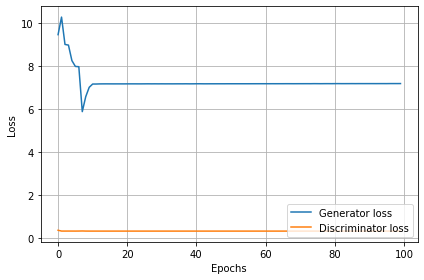

In [123]:
graph_loss(loss_dict, save=True, path='./GAN_graph.png')

In [124]:
images = []
for e in range(EPOCHS):
    img_name = 'Results/Fixed/' + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave('Results/generation_animation.gif', images, fps=5)